In [1]:
# Analyze gene expression of Ca Chx. allophototropha relatives from L221 / L304
# Jackson M. Tsuji, 2021
# Used for Figure 3b of the Chlorohelix publication
# NOTE: this code contains several manually defined elements and should not be used generically.

In [2]:
import os
import pandas as pd
import numpy as np
from Bio.SeqIO.FastaIO import SimpleFastaParser
from plotnine import *

In [3]:
# Variables
chx_mag_ids = ['MAG319', 'MAG729']
sample_metadata_filepath = 'input_data/sample_metadata.tsv'
featureCounts_fileapth = 'input_data/Ca_Chloroheliales_MAGs_featureCounts.tsv'
eggnog_filepath = 'input_data/Ca_Chloroheliales_MAGs_eggNog_annotations.tsv'
orf2gene_filepath = 'input_data/Ca_Chloroheliales_MAGs_orf2gene_mapping.tsv'

In [4]:
# Function to normalize hit counts for each MAG based on a single-copy marker gene
def normalize_hits(count_table, mag_id, scg_id):

    # Column names relied on in this function
    # TODO - an automated way to specify these would be needed to easily use this code for other samples
    index_colnames = ['MAG', 'ORF', 'length_bp', 'Sequence', 'Gene', 'seed_eggNOG_ortholog',
           'seed_ortholog_evalue', 'seed_ortholog_score', 'predicted_gene_name',
           'GO_terms', 'KEGG_KO', 'BiGG_Reactions', 'Annotation_tax_scope',
           'Matching_OGs', 'best_OG|evalue|score', 'categories',
           'eggNOG_HMM_model_annotation']
    sample_colnames = ['Jun2018_L221_05m_A', 'Jun2018_L221_05m_B',
           'Jun2018_L221_05m_C', 'Jun2018_L304_06m_A', 'Jun2018_L304_06m_B',
           'Jun2018_L304_06m_C']
    
    featureCounts_norm = count_table[count_table['MAG'] == mag_id].set_index(index_colnames)

    # # For interest, get the percent of mapped reads
    # featureCounts_sum_counts = featureCounts_norm.sum()
    # featureCounts_perc = featureCounts_norm.div(featureCounts_sum_counts, axis=1) * 100

    # Divide all gene hit counts by gene length
    featureCounts_norm = featureCounts_norm.div(featureCounts_norm.index.get_level_values('length_bp'), axis=0)

    # Get the length-normalized hit count for the SCG
    scg_count = featureCounts_norm[featureCounts_norm.index.get_level_values('ORF') == scg_id].squeeze()
    
    # Divide all length-normalized gene hit counts by the length-normalized SCG count
    featureCounts_norm = featureCounts_norm.div(scg_count, axis=1)
    
    # log2 transform the result
    featureCounts_norm = featureCounts_norm.apply(np.log2)
    featureCounts_norm = featureCounts_norm.reset_index()

    # This data now represents the up/down regulation of the gene compared to dnaK in log2 units
    return(featureCounts_norm)

In [5]:
# Read metadata
metadata = pd.read_csv(sample_metadata_filepath, sep='\t')
metadata.head()

,rep-id,sample-id,plot-id
0,Jun2018_L221_05m_A,Jun2018_L221_05m,Lake 221
1,Jun2018_L221_05m_B,Jun2018_L221_05m,Lake 221
2,Jun2018_L221_05m_C,Jun2018_L221_05m,Lake 221
3,Jun2018_L304_06m_A,Jun2018_L304_06m,Lake 304
4,Jun2018_L304_06m_B,Jun2018_L304_06m,Lake 304


In [6]:
# Read RNA mapping count data
featureCounts = pd.read_csv(featureCounts_fileapth, sep='\t')

# Subset to the L304 and L221 samples
featureCounts_subset = featureCounts.set_index(['MAG','ORF','length_bp'])[metadata['rep-id']]\
  .reset_index()

featureCounts_subset.head()
#featureCounts.shape # 8274 rows

,MAG,ORF,length_bp,Jun2018_L221_05m_A,Jun2018_L221_05m_B,Jun2018_L221_05m_C,Jun2018_L304_06m_A,Jun2018_L304_06m_B,Jun2018_L304_06m_C
0,MAG319,MAG319_1_1,540,8,10,13,8,4,8
1,MAG319,MAG319_1_2,516,0,0,0,2,4,0
2,MAG319,MAG319_1_3,975,2,0,8,2,2,2
3,MAG319,MAG319_1_4,1020,6,2,2,2,2,0
4,MAG319,MAG319_1_5,747,0,2,2,2,0,0


In [7]:
# Load gene annotation data
# orf2gene is used for mapping gene clusters (used for annotation) to their respective ORF IDs in the genomes
orf2gene_mapping_data = pd.read_csv(orf2gene_filepath, sep='\t')

# Load the eggNog annotation data and merge on the orf2gene mapping info
eggnog_data = pd.read_csv(eggnog_filepath, sep='\t')\
  .rename(columns={'query_name':'Gene'})\
  .merge(orf2gene_mapping_data, on='Gene', how='left')

eggnog_data.head()

,Gene,seed_eggNOG_ortholog,seed_ortholog_evalue,seed_ortholog_score,predicted_gene_name,GO_terms,KEGG_KO,BiGG_Reactions,Annotation_tax_scope,Matching_OGs,best_OG|evalue|score,categories,eggNOG_HMM_model_annotation,ORF
0,Gene0013075,309801.trd_1542,8.500000e-10,70.1,NaN,NaN,NaN,NaN,bactNOG[38],"06EAY@bactNOG,0XXWW@NOG",NA|NA|NA,NaN,NaN,MAG319_1_4
1,Gene0013076,765420.OSCT_2286,5.900000e-149,532.7,WECC,NaN,"K02472,K13015",UDPGD,bactNOG[38],"08IJ1@bactNOG,0D5YF@chloNOG,0D8Y1@chlorNOG,COG...",NA|NA|NA,M,Nucleotide sugar dehydrogenase,MAG319_1_36
2,Gene0013077,309801.trd_1669,4.400000e-76,289.7,NaN,NaN,NaN,NaN,bactNOG[38],"08KAC@bactNOG,0D1FX@chloNOG,COG2197@NOG",NA|NA|NA,T,"two component transcriptional regulator, LuxR ...",MAG319_1_68
3,Gene0013078,525904.Tter_1404,1.700000e-84,318.5,NaN,NaN,K09121,NaN,bactNOG[38],"05C8M@bactNOG,COG1641@NOG",NA|NA|NA,S,UPF0272 protein,MAG319_1_100
4,Gene0013079,326427.Cagg_2800,6.700000e-21,105.5,HUP,NaN,K03530,NaN,bactNOG[38],"05K70@bactNOG,0D333@chloNOG,0D6P8@chlorNOG,COG...",NA|NA|NA,L,histone family protein DNA-binding,MAG319_1_132


In [8]:
# Load the predicted amino acid sequences for the two genomes as a pandas dataframe
seq_tables = []
for mag_id in chx_mag_ids:
    
    with open(os.path.join('input_data', mag_id + '.faa'), 'r') as fasta_data:
        fasta_ids = []
        fasta_seqs = []

        for id, seq in SimpleFastaParser(fasta_data):
            fasta_ids.append(id.split(' ')[0])
            fasta_seqs.append(seq)

    seq_dict = {'ORF': fasta_ids, 'Sequence': fasta_seqs}
    seq_table = pd.DataFrame(seq_dict)

    seq_tables.append(seq_table)

fasta_data = pd.concat(seq_tables)
fasta_data.head()

,ORF,Sequence
0,MAG319_1_1,MQLVVQSGAEPGRTYDLRPGKLSLGRQSVNDVVISDEQASRRHADL...
1,MAG319_1_2,MNERILKREKLAEFGEICRKQGKRLIFTNGVFDLMHVGHVRCLSDA...
2,MAG319_1_3,MPLFEGKSVVVVGDLYHDEYIMGKPSRISREAPIVVLEYRSRRIVP...
3,MAG319_1_4,MSTSHRNEIDSNPNPEDRIYLKCGECGKAVLTREMTLIAEGVRCRE...
4,MAG319_1_5,MESHNILGVRVDDVTLDDAVALIEGWAHEKVSPARLIVTANPEYVM...


In [9]:
# Bind all of the loaded file info together
featureCounts_merged = featureCounts_subset\
  .merge(fasta_data, on='ORF', how='left')\
  .merge(eggnog_data, on='ORF', how='left')

featureCounts_merged.head()

,MAG,ORF,length_bp,Jun2018_L221_05m_A,Jun2018_L221_05m_B,Jun2018_L221_05m_C,Jun2018_L304_06m_A,Jun2018_L304_06m_B,Jun2018_L304_06m_C,Sequence,...,seed_ortholog_score,predicted_gene_name,GO_terms,KEGG_KO,BiGG_Reactions,Annotation_tax_scope,Matching_OGs,best_OG|evalue|score,categories,eggNOG_HMM_model_annotation
0,MAG319,MAG319_1_1,540,8,10,13,8,4,8,MQLVVQSGAEPGRTYDLRPGKLSLGRQSVNDVVISDEQASRRHADL...,...,102.8,CLOSI,NaN,K08587,NaN,bactNOG[38],"08X2E@bactNOG,0D3QR@chloNOG,0D6UI@chlorNOG,11K...",NA|NA|NA,S,peptidase C11 clostripain
1,MAG319,MAG319_1_2,516,0,0,0,2,4,0,MNERILKREKLAEFGEICRKQGKRLIFTNGVFDLMHVGHVRCLSDA...,...,166.4,AUT,NaN,NaN,NaN,bactNOG[38],"07Z67@bactNOG,0D2KB@chloNOG,COG2870@NOG",NA|NA|NA,M,RfaE bifunctional protein
2,MAG319,MAG319_1_3,975,2,0,8,2,2,2,MPLFEGKSVVVVGDLYHDEYIMGKPSRISREAPIVVLEYRSRRIVP...,...,250.8,RFAE,NaN,K03272,NaN,bactNOG[38],"07RFE@bactNOG,0D22I@chloNOG,COG2870@NOG",NA|NA|NA,M,PfkB domain protein
3,MAG319,MAG319_1_4,1020,6,2,2,2,2,0,MSTSHRNEIDSNPNPEDRIYLKCGECGKAVLTREMTLIAEGVRCRE...,...,70.1,NaN,NaN,NaN,NaN,bactNOG[38],"06EAY@bactNOG,0XXWW@NOG",NA|NA|NA,NaN,NaN
4,MAG319,MAG319_1_5,747,0,2,2,2,0,0,MESHNILGVRVDDVTLDDAVALIEGWAHEKVSPARLIVTANPEYVM...,...,222.6,WECG,"GO:0005575,GO:0005618,GO:0005623,GO:0030312,GO...","K02852,K05946",ACMAMUT,bactNOG[38],"08UHC@bactNOG,0D29E@chloNOG,0D7HU@chlorNOG,COG...",NA|NA|NA,M,"Glycosyl transferase, WecB TagA CpsF family"


In [10]:
# Look for dnaK (single copy gene marker; SCG) in each MAG for read count normalization
featureCounts_merged[featureCounts_merged['predicted_gene_name'] == 'DNAK']

# Result: single annotated copy for MAG319, but two annotated copies for MAG729
# As described in the paper, I then manually searched the sequences for these hits via BLASTP
#  and found that MAG729_10_15 was likely not valid. I will not use MAG729_10_15 further.

,MAG,ORF,length_bp,Jun2018_L221_05m_A,Jun2018_L221_05m_B,Jun2018_L221_05m_C,Jun2018_L304_06m_A,Jun2018_L304_06m_B,Jun2018_L304_06m_C,Sequence,...,seed_ortholog_score,predicted_gene_name,GO_terms,KEGG_KO,BiGG_Reactions,Annotation_tax_scope,Matching_OGs,best_OG|evalue|score,categories,eggNOG_HMM_model_annotation
474,MAG319,MAG319_3_43,1899,76,60,70,48,32,70,MGKILGIDLGTTNSVMAIMEGGEPVVIPNAEGNRTTPSVVAVNKQG...,...,899.4,DNAK,NaN,K04043,NaN,bactNOG[38],"05CFG@bactNOG,COG0443@NOG",NA|NA|NA,O,Acts as a chaperone (By similarity)
3822,MAG729,MAG729_10_15,1602,0,0,0,2,2,0,MITGKQTPPAVGIDIGTSFGRVALVQAGETNPKLVADGYGRVHQPA...,...,244.2,DNAK,NaN,K04043,NaN,bactNOG[38],"05CFG@bactNOG,0G80C@deiNOG,COG0443@NOG",NA|NA|NA,O,Acts as a chaperone (By similarity)
6074,MAG729,MAG729_257_1,1917,20,28,32,56,52,42,MGKILGIDLGTTNSAMAIMEGGEAVVIPNAEGARTTPSVVAVSKSG...,...,898.7,DNAK,NaN,K04043,NaN,bactNOG[38],"05CFG@bactNOG,COG0443@NOG",NA|NA|NA,O,Acts as a chaperone (By similarity)


In [11]:
# Using the selected SCGs above, normalize the hit counts for both MAGs
# TODO - the SCG IDs are entered here manually. This will not work well for future automation of the code
featureCounts_norm_MAG729 = normalize_hits(featureCounts_merged, 'MAG729', 'MAG729_257_1')
featureCounts_norm_MAG319 = normalize_hits(featureCounts_merged, 'MAG319', 'MAG319_3_43')

featureCounts_norm = pd.concat([featureCounts_norm_MAG729, featureCounts_norm_MAG319])
featureCounts_norm.head()

,MAG,ORF,length_bp,Sequence,Gene,seed_eggNOG_ortholog,seed_ortholog_evalue,seed_ortholog_score,predicted_gene_name,GO_terms,...,Matching_OGs,best_OG|evalue|score,categories,eggNOG_HMM_model_annotation,Jun2018_L221_05m_A,Jun2018_L221_05m_B,Jun2018_L221_05m_C,Jun2018_L304_06m_A,Jun2018_L304_06m_B,Jun2018_L304_06m_C
0,MAG729,MAG729_1_1,813,RRGLELKDVAIAAAREAGKLMLDWRKDFPPGPVTMAYKGAKDVITE...,Gene1472040,56780.SYN_00928,1.400000e-44,185.3,SUHB,"GO:0000287,GO:0003674,GO:0003824,GO:0005488,GO...",...,"05ECY@bactNOG,0GDEW@delNOG,0HEKF@dproNOG,16Q31...",NA|NA|NA,G,Inositol monophosphatase,-0.499443,-0.247904,0.044878,-0.984869,-1.462917,-1.154794
1,MAG729,MAG729_1_2,1122,MTQEVLNLSEAAECFLKDVGRGHSPATKNTYQVALNGFFQYLERQL...,Gene1071454,926569.ANT_15680,1.600000e-30,139.0,XERC,"GO:0005575,GO:0005622,GO:0005623,GO:0005737,GO...",...,COG0582@NOG,NA|NA|NA,L,Integrase,-2.549150,-3.034577,-2.227222,-inf,-3.927662,-inf
2,MAG729,MAG729_1_3,1323,MSALKLFYEDEDGKGKPVMSQRSMESHPVEEATDPAQLEKFNPLSP...,Gene1357320,485913.Krac_2047,2.300000e-84,318.2,CYPA,"GO:0005575,GO:0005623,GO:0005886,GO:0016020,GO...",...,"06A3M@bactNOG,0D3V1@chloNOG,COG2124@NOG",NA|NA|NA,Q,cytochrome P450,-2.786891,-2.272318,-inf,-1.950390,-3.165402,-2.535352
3,MAG729,MAG729_1_4,711,MSRTENQNKGLVAQIEVDWQETSPSKKPARLMKATDFLNGTASGCS...,Gene1299736,388400.BB14905_18810,1.900000e-08,65.1,GSIB,NaN,...,COG3729@NOG,NA|NA|NA,S,"Stress-induced protein, KGG, repeat protein",0.693963,-0.054498,-0.569071,-1.791464,-0.684548,-0.639460
4,MAG729,MAG729_1_5,1527,MNLRLPQRKALEIVARSQPREIYLVGGFVRDTLLGRESADIDLGVP...,Gene0840603,765420.OSCT_0415,3.100000e-40,171.8,CCAC,NaN,...,"05D4J@bactNOG,0D1RG@chloNOG,0D656@chlorNOG,COG...",NA|NA|NA,J,polynucleotide adenylyltransferase metal depen...,-1.408815,-1.479205,-1.671850,-1.894242,-1.564935,-3.064167


In [12]:
# Now get averages and standard deviations for the normalized values

# First, make the table long format
index_colnames = ['MAG', 'ORF', 'length_bp', 'Sequence', 'Gene', 'seed_eggNOG_ortholog',
          'seed_ortholog_evalue', 'seed_ortholog_score', 'predicted_gene_name',
          'GO_terms', 'KEGG_KO', 'BiGG_Reactions', 'Annotation_tax_scope',
          'Matching_OGs', 'best_OG|evalue|score', 'categories',
          'eggNOG_HMM_model_annotation']
featureCounts_norm_avg = featureCounts_norm.melt(id_vars=index_colnames,
                                                value_vars=metadata['rep-id'], 
                                                var_name='rep-id', 
                                                value_name='normalized_expression')\
 .merge(metadata, on='rep-id', how='left')

# Temporarily replace NaN values (because they are silently dropped in the pivot step!)
featureCounts_norm_avg = featureCounts_norm_avg.fillna('NA_tmp')

# Now calculate the means and standard deviations for each sample-id
featureCounts_norm_avg = featureCounts_norm_avg.groupby(index_colnames + ['plot-id'])\
  .agg({'normalized_expression':['mean','std']})\
  .reset_index()\
  .replace('NA_tmp', '')

# Flatten index
featureCounts_norm_avg.columns = ['_'.join(colname).rstrip('_') for colname in featureCounts_norm_avg.columns.to_flat_index()]

featureCounts_norm_avg.head()

,MAG,ORF,length_bp,Sequence,Gene,seed_eggNOG_ortholog,seed_ortholog_evalue,seed_ortholog_score,predicted_gene_name,GO_terms,KEGG_KO,BiGG_Reactions,Annotation_tax_scope,Matching_OGs,best_OG|evalue|score,categories,eggNOG_HMM_model_annotation,plot-id,normalized_expression_mean,normalized_expression_std
0,MAG319,MAG319_100_1,2076,ARTVRLYPLPLKGRGFTRLAIKERTAPGTRLHTLLQYGNAVIQEGR...,,,,,,,,,,,,,,Lake 221,-inf,NaN
1,MAG319,MAG319_100_1,2076,ARTVRLYPLPLKGRGFTRLAIKERTAPGTRLHTLLQYGNAVIQEGR...,,,,,,,,,,,,,,Lake 304,-inf,NaN
2,MAG319,MAG319_101_1,621,MLNFKRRSALFLVGLLLAVLMVACGDSANTQVSTTATATTAAATTT...,,,,,,,,,,,,,,Lake 221,-1.179829,0.215059
3,MAG319,MAG319_101_1,621,MLNFKRRSALFLVGLLLAVLMVACGDSANTQVSTTATATTAAATTT...,,,,,,,,,,,,,,Lake 304,-1.902199,0.500654
4,MAG319,MAG319_101_2,513,MPQRHRAGQPVYQQVYQAGIASSPWQHLDTTITRVEGNNYNCHILT...,,,,,,,,,,,,,,Lake 221,-inf,NaN


In [13]:
# Make wide format table and export as Supplementary Data 5
featureCounts_norm_avg_wide = featureCounts_norm_avg\
  .pivot(index=index_colnames, columns='plot-id', 
         values=['normalized_expression_mean', 'normalized_expression_std'])\
  .reset_index()\
  .sort_values(by=('normalized_expression_mean','Lake 221'), ascending=False)

featureCounts_norm_avg_wide.to_csv('supplementary_data_5_raw.tsv', sep='\t', index=False)

featureCounts_norm_avg_wide.head()
# featureCounts_norm_avg_wide.shape # 8274 rows, like the original table; good.

MAG           ORF length_bp  \
plot-id                                   
3705     MAG729  MAG729_107_3       216   
5430     MAG729  MAG729_309_3       255   
3706     MAG729  MAG729_107_4       216   
1047     MAG319  MAG319_20_30       219   
2166     MAG319   MAG319_3_26       246   

                                                  Sequence         Gene  \
plot-id                                                                   
3705     MAVEKTIGSSSLVEVIDRILDKGIVIDAWARVSLVGIELVAIEARV...  Gene0038657   
5430     MAGLVAKTASDAVEFFEVQTDGWWMWVSGILRTTGDAIERICVNTW...                
3706     MAVEKTIGSSSLVEVIDRILDKGIVIDAWARVSLVGIELVAIEARV...  Gene0038657   
1047     MAVEKTNSSSSLVEVIDRILDKGIVIDAWARVSLVGIELLAIEARV...  Gene0626160   
2166     MAGMVARVASDAAEFFEVQTDGWWMWVSGVLRTTGDAIERICSNTW...                

        seed_eggNOG_ortholog seed_ortholog_evalue seed_ortholog_score  \
plot-id                                                                 
3705        449447.MAE_37580              5.2e-26               121.7   
5430                                                                    
3706        449447.MAE_37580              5.2e-26               121.7   
1047        449447.MAE_37580              2.8e-27               125.9   
2166                                                                    

        predicted_gene_name  \
plot-id                       
3705                   GVPA   
5430                          
3706                   GVPA   
1047                   GVPA   
2166                          

                                                  GO_terms  ...  \
plot-id                                                     ...   
3705     GO:0005575,GO:0005622,GO:0005623,GO:0005737,GO...  ...   
5430                                                        ...   
3706     GO:0005575,GO:0005622,GO:0005623,GO:0005737,GO...  ...   
1047     GO:0005575,GO:0005622,GO:0005623,GO:0005737,GO...  ...   
2166                                                        ...   

        BiGG_Reactions Annotation_tax_scope  \
plot-id                                       
3705                            bactNOG[38]   
5430                                          
3706                            bactNOG[38]   
1047                            bactNOG[38]   
2166                                          

                                 Matching_OGs best_OG|evalue|score categories  \
plot-id                                                                         
3705     05MRC@bactNOG,0FNUK@cyaNOG,1257U@NOG             NA|NA|NA          S   
5430                                                                            
3706     05MRC@bactNOG,0FNUK@cyaNOG,1257U@NOG             NA|NA|NA          S   
1047     05MRC@bactNOG,0FNUK@cyaNOG,1257U@NOG             NA|NA|NA          S   
2166                                                                            

                               eggNOG_HMM_model_annotation  \
plot-id                                                      
3705     Gas vesicles are small, hollow, gas filled pro...   
5430                                                         
3706     Gas vesicles are small, hollow, gas filled pro...   
1047     Gas vesicles are small, hollow, gas filled pro...   
2166                                                         

        normalized_expression_mean           normalized_expression_std  \
plot-id                   Lake 221  Lake 304                  Lake 221   
3705                      9.080794  8.527529                  0.421628   
5430                      8.913646  7.996922                  0.397975   
3706                      8.602749  8.475696                  0.429987   
1047                      7.561383  6.562233                  0.151954   
2166                      7.184690  6.695277                  0.015196   

                   
plot-id  Lake 304  
3705     0.257523  
5430     0.251246  
3706     0.197668  
1047     0.535264  
2166     0.5

In [14]:
# Prep long format data for plotting
plotting_data = featureCounts_norm_avg\
  .sort_values(by='normalized_expression_mean', ascending=False)

# Make axis label that combines the gene annotation and unique ID
plotting_data['axis_labels'] = plotting_data['predicted_gene_name'] + ' (' + plotting_data['ORF'] + ')'

# Get lists of top 50 expressed genes from each sample / MAG
top50_ids = []
for mag in chx_mag_ids:
    for sample_name in plotting_data['plot-id'].unique():
        top50_ids = top50_ids + list(plotting_data[(plotting_data['plot-id'] == sample_name) & (plotting_data['MAG'] == mag)]['axis_labels'][0:50])

# Collapse to unique entries
top50_ids = list(set(top50_ids))

# Sort by max expression
plotting_order = plotting_data[plotting_data['axis_labels'].isin(top50_ids)][['axis_labels','normalized_expression_mean']]\
  .groupby(['axis_labels']).agg('max')\
  .reset_index()\
  .sort_values(by='normalized_expression_mean', ascending=False)['axis_labels'].to_list()

# Collapse to those top 50
plotting_data_subset = plotting_data.copy(deep=True)[plotting_data['axis_labels'].isin(top50_ids)]

# Export this plotting data (keeping only one annotation entry per gene) for manual inspection
plotting_data_subset.drop(columns=['plot-id','normalized_expression_mean','normalized_expression_std'])\
  .drop_duplicates()\
  .to_csv('Chloroheliales_expression_plotting_table_raw.tsv', sep='\t', index=False)
# I then manually worked through the file and made a custom column, 'axis_labels_curated', 
#    to manually curate the annotation labels

plotting_data_subset.head()

,MAG,ORF,length_bp,Sequence,Gene,seed_eggNOG_ortholog,seed_ortholog_evalue,seed_ortholog_score,predicted_gene_name,GO_terms,...,BiGG_Reactions,Annotation_tax_scope,Matching_OGs,best_OG|evalue|score,categories,eggNOG_HMM_model_annotation,plot-id,normalized_expression_mean,normalized_expression_std,axis_labels
7410,MAG729,MAG729_107_3,216,MAVEKTIGSSSLVEVIDRILDKGIVIDAWARVSLVGIELVAIEARV...,Gene0038657,449447.MAE_37580,5.2e-26,121.7,GVPA,"GO:0005575,GO:0005622,GO:0005623,GO:0005737,GO...",...,,bactNOG[38],"05MRC@bactNOG,0FNUK@cyaNOG,1257U@NOG",NA|NA|NA,S,"Gas vesicles are small, hollow, gas filled pro...",Lake 221,9.080794,0.421628,GVPA (MAG729_107_3)
10860,MAG729,MAG729_309_3,255,MAGLVAKTASDAVEFFEVQTDGWWMWVSGILRTTGDAIERICVNTW...,,,,,,,...,,,,,,,Lake 221,8.913646,0.397975,(MAG729_309_3)
7412,MAG729,MAG729_107_4,216,MAVEKTIGSSSLVEVIDRILDKGIVIDAWARVSLVGIELVAIEARV...,Gene0038657,449447.MAE_37580,5.2e-26,121.7,GVPA,"GO:0005575,GO:0005622,GO:0005623,GO:0005737,GO...",...,,bactNOG[38],"05MRC@bactNOG,0FNUK@cyaNOG,1257U@NOG",NA|NA|NA,S,"Gas vesicles are small, hollow, gas filled pro...",Lake 221,8.602749,0.429987,GVPA (MAG729_107_4)
7411,MAG729,MAG729_107_3,216,MAVEKTIGSSSLVEVIDRILDKGIVIDAWARVSLVGIELVAIEARV...,Gene0038657,449447.MAE_37580,5.2e-26,121.7,GVPA,"GO:0005575,GO:0005622,GO:0005623,GO:0005737,GO...",...,,bactNOG[38],"05MRC@bactNOG,0FNUK@cyaNOG,1257U@NOG",NA|NA|NA,S,"Gas vesicles are small, hollow, gas filled pro...",Lake 304,8.527529,0.257523,GVPA (MAG729_107_3)
7413,MAG729,MAG729_107_4,216,MAVEKTIGSSSLVEVIDRILDKGIVIDAWARVSLVGIELVAIEARV...,Gene0038657,449447.MAE_37580,5.2e-26,121.7,GVPA,"GO:0005575,GO:0005622,GO:0005623,GO:0005737,GO...",...,,bactNOG[38],"05MRC@bactNOG,0FNUK@cyaNOG,1257U@NOG",NA|NA|NA,S,"Gas vesicles are small, hollow, gas filled pro...",Lake 304,8.475696,0.197668,GVPA (MAG729_107_4)


In [16]:
# Load the custom annotation labels
custom_annotations = pd.read_csv('Chloroheliales_expression_plotting_table_curated.tsv', sep='\t')\
  [['ORF','Category','Name','axis_labels_curated']]
custom_annotations.head()

,ORF,Category,Name,axis_labels_curated
0,MAG319_27_22,Other,Extracellular ligand-binding receptor,Extracellular ligand-binding receptor (MAG319_...
1,MAG319_39_1,Other,oppA,oppA (MAG319_39_1)
2,MAG729_240_2,Other,atpE,atpE (MAG729_240_2)
3,MAG729_240_3,Other,atpF,atpF (MAG729_240_3)
4,MAG319_12_2,Other,lacD,lacD (MAG319_12_2)


In [17]:
# Prep the data for plotting
plotting_data_custom = plotting_data_subset.merge(custom_annotations, on='ORF', how='left')

# Sort by max expression
plotting_order_custom = plotting_data_custom[['axis_labels_curated','normalized_expression_mean']]\
  .groupby(['axis_labels_curated']).agg('max')\
  .reset_index()\
  .sort_values(by='normalized_expression_mean', ascending=True)['axis_labels_curated'].to_list()

# Make categorical to set the plotter order in plotnine
plotting_data_custom['axis_labels_curated'] = pd.Categorical(plotting_data_custom['axis_labels_curated'], 
                                                             categories=plotting_order_custom, ordered=True)

# Custom category order
# TODO - it would be better to keep this information in a separate metadata file that could be loaded
category_order = ['Phototrophy', 'CBB cycle', 'Gas vesicle', 'Other', 'Unknown']
plotting_colours = ['#66a61e', '#e6ab02', '#7570b3', '#8c8c8c', '#ffffff']
plotting_data_custom['Category'] = pd.Categorical(plotting_data_custom['Category'], categories=category_order, ordered=True)

plotting_data_custom.head()

,MAG,ORF,length_bp,Sequence,Gene,seed_eggNOG_ortholog,seed_ortholog_evalue,seed_ortholog_score,predicted_gene_name,GO_terms,...,best_OG|evalue|score,categories,eggNOG_HMM_model_annotation,plot-id,normalized_expression_mean,normalized_expression_std,axis_labels,Category,Name,axis_labels_curated
0,MAG729,MAG729_107_3,216,MAVEKTIGSSSLVEVIDRILDKGIVIDAWARVSLVGIELVAIEARV...,Gene0038657,449447.MAE_37580,5.2e-26,121.7,GVPA,"GO:0005575,GO:0005622,GO:0005623,GO:0005737,GO...",...,NA|NA|NA,S,"Gas vesicles are small, hollow, gas filled pro...",Lake 221,9.080794,0.421628,GVPA (MAG729_107_3),Gas vesicle,gvpA,gvpA (MAG729_107_3)
1,MAG729,MAG729_309_3,255,MAGLVAKTASDAVEFFEVQTDGWWMWVSGILRTTGDAIERICVNTW...,,,,,,,...,,,,Lake 221,8.913646,0.397975,(MAG729_309_3),Unknown,Unclassified,MAG729_309_3
2,MAG729,MAG729_107_4,216,MAVEKTIGSSSLVEVIDRILDKGIVIDAWARVSLVGIELVAIEARV...,Gene0038657,449447.MAE_37580,5.2e-26,121.7,GVPA,"GO:0005575,GO:0005622,GO:0005623,GO:0005737,GO...",...,NA|NA|NA,S,"Gas vesicles are small, hollow, gas filled pro...",Lake 221,8.602749,0.429987,GVPA (MAG729_107_4),Gas vesicle,gvpA,gvpA (MAG729_107_4)
3,MAG729,MAG729_107_3,216,MAVEKTIGSSSLVEVIDRILDKGIVIDAWARVSLVGIELVAIEARV...,Gene0038657,449447.MAE_37580,5.2e-26,121.7,GVPA,"GO:0005575,GO:0005622,GO:0005623,GO:0005737,GO...",...,NA|NA|NA,S,"Gas vesicles are small, hollow, gas filled pro...",Lake 304,8.527529,0.257523,GVPA (MAG729_107_3),Gas vesicle,gvpA,gvpA (MAG729_107_3)
4,MAG729,MAG729_107_4,216,MAVEKTIGSSSLVEVIDRILDKGIVIDAWARVSLVGIELVAIEARV...,Gene0038657,449447.MAE_37580,5.2e-26,121.7,GVPA,"GO:0005575,GO:0005622,GO:0005623,GO:0005737,GO...",...,NA|NA|NA,S,"Gas vesicles are small, hollow, gas filled pro...",Lake 304,8.475696,0.197668,GVPA (MAG729_107_4),Gas vesicle,gvpA,gvpA (MAG729_107_4)


/Analysis/jmtsuji/miniconda3_mellea/envs/jupyterlab/lib/python3.7/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/Analysis/jmtsuji/miniconda3_mellea/envs/jupyterlab/lib/python3.7/site-packages/plotnine/layer.py:464: PlotnineWarning: geom_errorbarh : Removed 2 rows containing missing values.


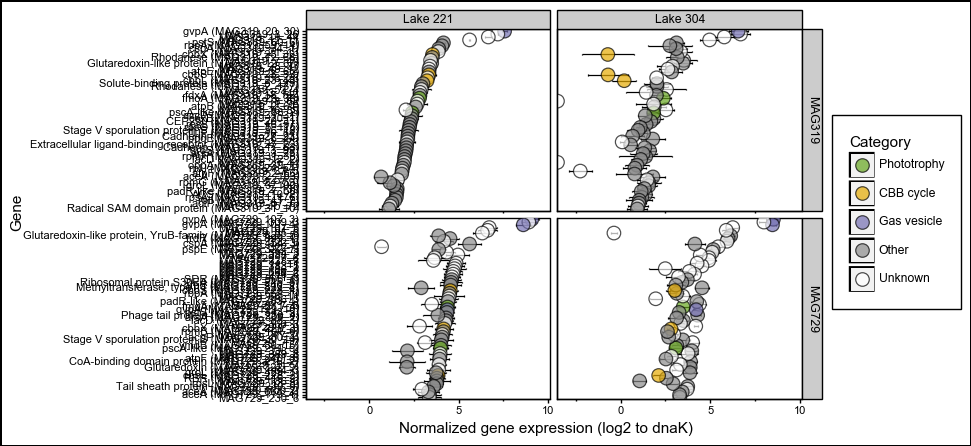

<ggplot: (-9223363309141292491)>


In [18]:
# Make Extended Data Figure 7
expression_plot_ED7 = (ggplot(plotting_data_custom, aes(y='axis_labels_curated', x='normalized_expression_mean'))
                   + geom_errorbarh(aes(xmax='normalized_expression_mean+normalized_expression_std',
                                      xmin='normalized_expression_mean-normalized_expression_std'))
                   + geom_point(aes(fill='Category'), size=5, alpha=0.7)
                   + facet_grid('MAG ~ plot-id', scales='free_y')
                   + scale_fill_manual(values=plotting_colours)
                   + theme_bw()
                   + theme(text=element_text(family='Arial', colour='black'),
                          panel_grid=element_blank(),
                          axis_text=element_text(size=8),
                          line=element_line(colour='black'),
                          rect=element_rect(colour='black'))
                   + xlab('Normalized gene expression (log2 to dnaK)')
                   + ylab('Gene'))

print(expression_plot_ED7)

In [19]:
expression_plot_ED7.save('Figure_ED7_raw.pdf', width=150, height=400, units='mm')

/Analysis/jmtsuji/miniconda3_mellea/envs/jupyterlab/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 150.0 x 400.0 mm image.
/Analysis/jmtsuji/miniconda3_mellea/envs/jupyterlab/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: Figure_ED7_raw.pdf
/Analysis/jmtsuji/miniconda3_mellea/envs/jupyterlab/lib/python3.7/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/Analysis/jmtsuji/miniconda3_mellea/envs/jupyterlab/lib/python3.7/site-packages/plotnine/layer.py:464: PlotnineWarning: geom_errorbarh : Removed 2 rows containing missing values.


In [20]:
# Now make a subset of only MAG319, L221, top 30 genes, for Figure 3b
plotting_data_custom_Fig3b = plotting_data_custom[(plotting_data_custom['MAG'] == 'MAG319') & \
                                                  (plotting_data_custom['plot-id'] == 'Lake 221')]\
  .sort_values(by='normalized_expression_mean', ascending=False)

# Get lists of top 30 expressed genes
top30_ids = list(plotting_data_custom_Fig3b['axis_labels_curated'][0:30])

# Collapse to those top 30 and make categorical
plotting_data_custom_Fig3b = plotting_data_custom_Fig3b[plotting_data_custom_Fig3b['axis_labels_curated'].isin(top30_ids)]
plotting_data_custom_Fig3b['axis_labels_curated'] = list(plotting_data_custom_Fig3b['axis_labels_curated'])
plotting_data_custom_Fig3b['axis_labels_curated'] = pd.Categorical(plotting_data_custom_Fig3b['axis_labels_curated'], 
                                                       categories=plotting_data_custom_Fig3b['axis_labels_curated'], 
                                                       ordered=True)

plotting_data_custom_Fig3b.head()

,MAG,ORF,length_bp,Sequence,Gene,seed_eggNOG_ortholog,seed_ortholog_evalue,seed_ortholog_score,predicted_gene_name,GO_terms,...,best_OG|evalue|score,categories,eggNOG_HMM_model_annotation,plot-id,normalized_expression_mean,normalized_expression_std,axis_labels,Category,Name,axis_labels_curated
6,MAG319,MAG319_20_30,219,MAVEKTNSSSSLVEVIDRILDKGIVIDAWARVSLVGIELLAIEARV...,Gene0626160,449447.MAE_37580,2.8e-27,125.9,GVPA,"GO:0005575,GO:0005622,GO:0005623,GO:0005737,GO...",...,NA|NA|NA,S,"Gas vesicles are small, hollow, gas filled pro...",Lake 221,7.561383,0.151954,GVPA (MAG319_20_30),Gas vesicle,gvpA,gvpA (MAG319_20_30)
7,MAG319,MAG319_3_26,246,MAGMVARVASDAAEFFEVQTDGWWMWVSGVLRTTGDAIERICSNTW...,,,,,,,...,,,,Lake 221,7.184690,0.015196,(MAG319_3_26),Unknown,Unclassified,MAG319_3_26
10,MAG319,MAG319_11_44,477,MAVIYLGTLQHRSCRRLHDCSRLLAPASNRLYPPTRRLLQGGLPFS...,,,,,,,...,,,,Lake 221,6.653233,0.178073,(MAG319_11_44),Unknown,Unclassified,MAG319_11_44
21,MAG319,MAG319_12_11,309,MADDIKIKVKDAEVDALEELDTEVGGSSGLFGVNVGKTVLNLVKLE...,,,,,,,...,,,,Lake 221,5.606593,0.011307,(MAG319_12_11),Unknown,Unclassified,MAG319_12_11
62,MAG319,MAG319_60_6,1281,MFKRTKSLNPKFLVALALTMLLALVLVACGDNTATTVPATTAAATT...,Gene1770816,65393.PCC7424_0541,3.7e-55,221.1,PSTS,,...,NA|NA|NA,P,Phosphate-binding protein,Lake 221,4.149425,0.065544,PSTS (MAG319_60_6),Other,pstS,pstS (MAG319_60_6)


/Analysis/jmtsuji/miniconda3_mellea/envs/jupyterlab/lib/python3.7/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


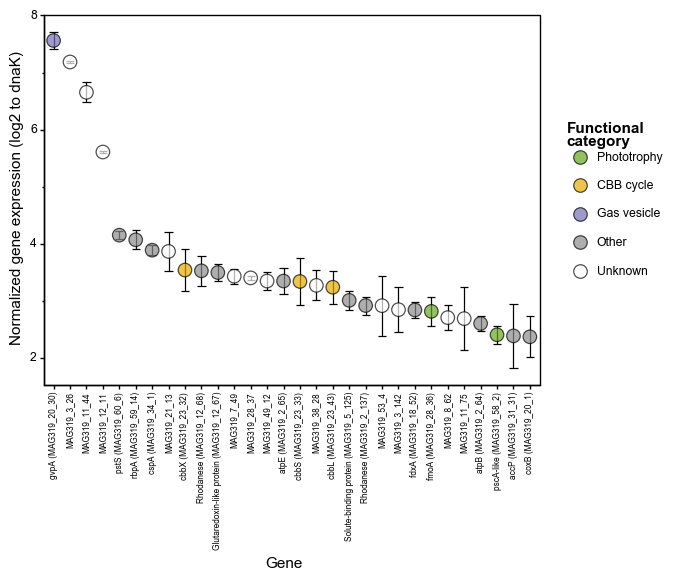

<ggplot: (8727709797517)>


In [21]:
# Plot Fig. 3b
expression_plot_3b = (ggplot(plotting_data_custom_Fig3b, aes(x='axis_labels_curated', y='normalized_expression_mean'))
                   + geom_errorbar(aes(ymax='normalized_expression_mean+normalized_expression_std',
                                      ymin='normalized_expression_mean-normalized_expression_std'))
                   + geom_point(aes(fill='Category'), size=5, alpha=0.7)
                   + scale_fill_manual(values=plotting_colours, guide=guide_legend(title='Functional\ncategory'))
                   + theme_bw()
                   + theme(text=element_text(family='Arial', colour='black'),
                          panel_grid=element_blank(),
                          axis_text_x=element_text(angle=90, size=6),
                          line=element_line(colour='black'),
                          panel_border=element_rect(colour='black'),
                          legend_key=element_blank(),
                          legend_margin=0,
                          legend_title=element_text(face='bold'),
                          strip_text=element_text(face='bold'),
                          strip_background=element_rect(colour='black'))
                   + ylab('Normalized gene expression (log2 to dnaK)')
                   + xlab('Gene'))

print(expression_plot_3b)

In [22]:
expression_plot_3b.save('Figure_3b_raw.pdf', width=100, height=70, units='mm')

/Analysis/jmtsuji/miniconda3_mellea/envs/jupyterlab/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 100.0 x 70.0 mm image.
/Analysis/jmtsuji/miniconda3_mellea/envs/jupyterlab/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: Figure_3b_raw.pdf
/Analysis/jmtsuji/miniconda3_mellea/envs/jupyterlab/lib/python3.7/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
